In [14]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def generate_tree(values, periods):
    """
    Génère un arbre binomial à partir d'une liste de valeurs
    
    Parameters:
    -----------
    values : list
        Liste des valeurs pour chaque nœud [période 0, période 1 up, période 1 down, etc.]
    periods : int
        Nombre de périodes (dimension de l'arbre)
    
    Returns:
    --------
    dict : Arbre sous forme de dictionnaire {période: {état: valeur}}
    """
    tree = {}
    value_index = 0
    
    for period in range(periods + 1):
        tree[period] = {}
        nodes_in_period = period + 1
        
        for state in range(nodes_in_period):
            if value_index < len(values):
                tree[period][state] = values[value_index]
                value_index += 1
            else:
                tree[period][state] = 0  # Valeur par défaut si pas assez de valeurs
                
    return tree

def plot_simple_tree(tree, title="Arbre Binomial"):
    """
    Dessine l'arbre de manière simple
    
    Parameters:
    -----------
    tree : dict
        Arbre à dessiner
    title : str
        Titre du graphique
    """
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    
    periods = len(tree) - 1
    node_radius = 0.3
    spacing_x = 2
    spacing_y = 1
    
    # Dessine les nœuds et les valeurs
    for period in range(periods + 1):
        for state in range(period + 1):
            if period in tree and state in tree[period]:
                value = tree[period][state]
                
                # Position du nœud
                x = period * spacing_x
                y = (periods - 2 * state) * spacing_y / 2
                
                # Dessine le cercle
                circle = patches.Circle((x, y), node_radius, 
                                      facecolor='lightblue', edgecolor='black', linewidth=2)
                ax.add_patch(circle)
                
                # Texte dans le nœud
                ax.text(x, y, f'{value}', ha='center', va='center', 
                       fontweight='bold', fontsize=10)
                
                # Dessine les liens
                if period < periods:
                    next_x = (period + 1) * spacing_x
                    
                    # Lien vers le haut (up)
                    next_y_up = (periods - 2 * state) * spacing_y / 2
                    ax.plot([x + node_radius, next_x - node_radius], 
                           [y, next_y_up], 'k-', linewidth=2)
                    
                    # Lien vers le bas (down)
                    next_y_down = (periods - 2 * (state + 1)) * spacing_y / 2
                    ax.plot([x + node_radius, next_x - node_radius], 
                           [y, next_y_down], 'k-', linewidth=2)
    
    # Labels des périodes
    for period in range(periods + 1):
        ax.text(period * spacing_x, -periods * spacing_y / 2 - 0.8, 
               f'T={period}', ha='center', va='top', fontweight='bold', fontsize=12)
    
    # Configuration
    ax.set_xlim(-0.5, periods * spacing_x + 0.5)
    ax.set_ylim(-periods * spacing_y / 2 - 1.5, periods * spacing_y / 2 + 0.5)
    ax.set_aspect('equal')
    ax.axis('off')
    ax.set_title(title, fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    return fig, ax

    plot_simple_tree(rate_tree, "Arbre des Taux d'Intérêt")

In [4]:
import numpy as np
import pandas as pd


# Paramètres du modèle
spot_6m = 0.02  # Taux 6 mois actuel
spot_1y = 0.0215  # Taux 1 an actuel

# Taux futurs possibles dans 6 mois (upstate/downstate)
rate_up = 0.015    # 1.5% (downstate dans l'exemple)
rate_down = 0.025  # 2.5% (upstate dans l'exemple)

# Probabilités
prob_up = 0.5
prob_down = 0.5

# Valeur faciale des obligations
face_value = 1000

# Option parameters
strike_price = 990

In [44]:
def calculate_bond_prices_at_6m(face_value, rate_up, rate_down):
    """Calcule les prix des obligations à 6 mois selon les scénarios"""
    # Prix obligation 6M à l'échéance = valeur faciale
    bond_6m_up = face_value
    bond_6m_down = face_value

    # Prix obligation 1Y dans 6 mois (devient obligation 6M)
    bond_1y_up = face_value / (1 + rate_up/2)  # 1.5%
    bond_1y_down = face_value / (1 + rate_down/2)  # 2.5%
    
    return {
        'bond_6m_up': bond_6m_up,
        'bond_6m_down': bond_6m_down,
        'bond_1y_up': bond_1y_up,
        'bond_1y_down': bond_1y_down
    }

def calculate_current_bond_prices(face_value, spot_6m, spot_1y):
    """Calcule les prix actuels des obligations"""
    bond_6m_current = face_value / (1 + spot_6m/2)
    bond_1y_current = face_value / (1 + spot_1y)
    
    return bond_6m_current, bond_1y_current

def calculate_option_payoffs(strike_price, bond_prices):
    """Calcule les payoffs de l'option call dans chaque scénario"""
    payoff_up = max(0, bond_prices['bond_1y_up'] - strike_price)
    payoff_down = max(0, bond_prices['bond_1y_down'] - strike_price)

    return payoff_up, payoff_down

def expected_discounted_value_method(prob_up, prob_down, payoff_up, payoff_down):
    """Méthode 1: Expected Discounted Value"""
    expected_payoff = prob_up * payoff_up + prob_down * payoff_down
    discount_factor = 1 + spot_6m/2

    option_price_edv = expected_payoff / discount_factor
    
    return {
        'expected_payoff': expected_payoff,
        'discount_factor': discount_factor,
        'option_price': option_price_edv
    }

def arbitrage_method(
        face_value, 
        bond_prices, 
        payoff_up, 
        payoff_down,
        spot_6m,
        spot_1y):
    """Méthode 2: Arbitrage Pricing"""
    bond_6m_current, bond_1y_current = calculate_current_bond_prices(face_value)

    # Prix unitaires (par dollar de valeur faciale)
    price_6m_unit = bond_6m_current / face_value
    price_1y_unit = bond_1y_current / face_value

    # Valeurs des obligations à 6M (par dollar de face value)
    bond_1y_unit_up = bond_prices['bond_1y_up'] / face_value
    bond_1y_unit_down = bond_prices['bond_1y_down'] / face_value

    # Système d'équations pour trouver le portefeuille réplicant
    # F^S + bond_1y_unit_up * F^1 = payoff_up
    # F^S + bond_1y_unit_down * F^1 = payoff_down
    
    # Résolution du système
    A = np.array([
        [1, bond_1y_unit_up],
        [1, bond_1y_unit_down]
    ])
    b = np.array([payoff_up, payoff_down])
    
    F_S, F_1 = np.linalg.solve(A, b)
    
    # Prix de l'option = prix du portefeuille réplicant
    option_price_arbitrage = price_6m_unit * F_S + price_1y_unit * F_1
    
    return {
        'F_S': F_S,
        'F_1': F_1,
        'option_price': option_price_arbitrage,
        'replicating_portfolio_value': price_6m_unit * F_S + price_1y_unit * F_1
    }

In [12]:

# 1. Calcul des prix des obligations
bond_prices = calculate_bond_prices_at_6m(
    face_value=face_value,
    rate_up=rate_up,
    rate_down=rate_down
)
bond_6m_current, bond_1y_current = calculate_current_bond_prices(
    face_value=face_value, 
    spot_6m=spot_6m, 
    spot_1y=spot_1y)

print("1. PRIX DES OBLIGATIONS:")
print(f"   Obligation 6M actuelle: ${bond_6m_current:.3f}")
print(f"   Obligation 1Y actuelle: ${bond_1y_current:.3f}")
print(f"   Obligation 1Y à 6M (up): ${bond_prices['bond_1y_up']:.3f}")
print(f"   Obligation 1Y à 6M (down): ${bond_prices['bond_1y_down']:.3f}\n")

1. PRIX DES OBLIGATIONS:
   Obligation 6M actuelle: $990.099
   Obligation 1Y actuelle: $978.953
   Obligation 1Y à 6M (up): $992.556
   Obligation 1Y à 6M (down): $987.654



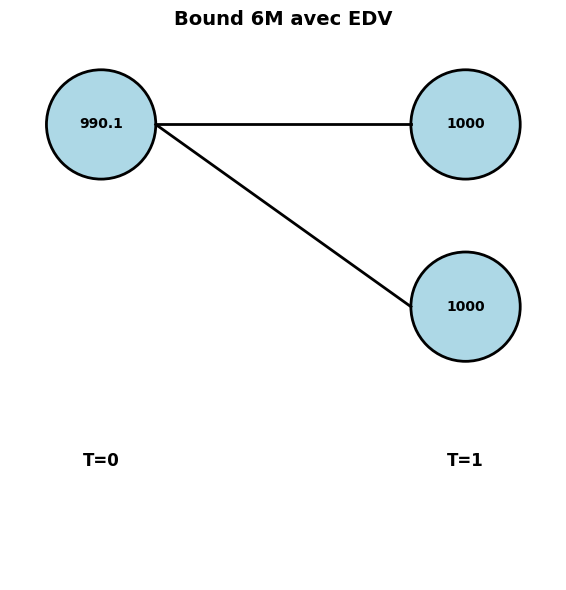

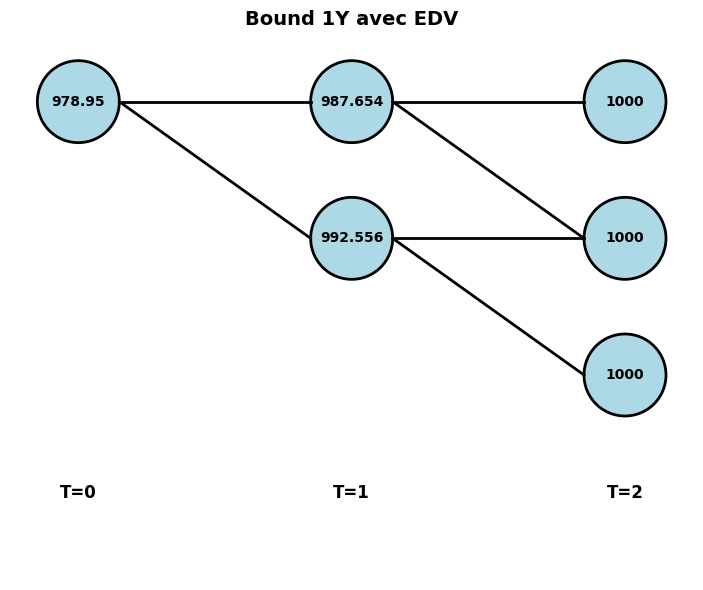

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Bound 1Y avec EDV'}>)

In [29]:

tree = generate_tree(
    [round(bond_6m_current, 2), 
     round(face_value, 2), round(face_value, 2)]  # Valeurs des nœuds
    , 
    1)
plot_simple_tree(tree, "Bound 6M avec EDV")

tree = generate_tree(
    [round(bond_1y_current, 2), 
    round(bond_prices['bond_1y_down'],3), round(bond_prices['bond_1y_up'],3),
     round(face_value, 2), round(face_value, 2), round(face_value, 2)]  # Valeurs des nœuds
    , 
    2)
plot_simple_tree(tree, "Bound 1Y avec EDV")

2. PAYOFFS DE L'OPTION CALL (Strike = $990):
   Scénario UP (taux 1.5%): $2.556
   Scénario DOWN (taux 2.5%): $0.000



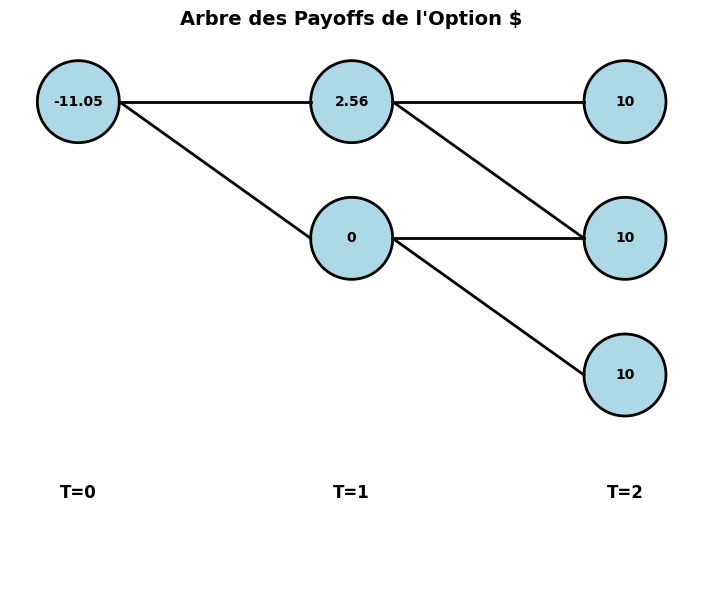

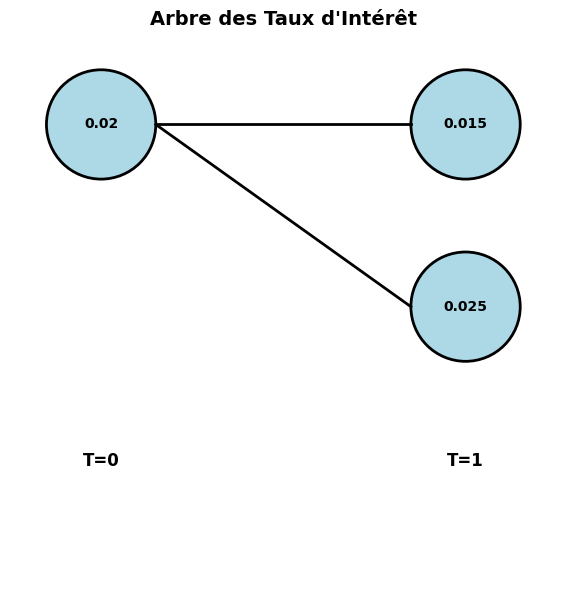

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': "Arbre des Taux d'Intérêt"}>)

In [38]:
# calcul des payoffs de l'option
payoff_up, payoff_down = calculate_option_payoffs(strike_price, bond_prices)
print("2. PAYOFFS DE L'OPTION CALL (Strike = $990):")
print(f"   Scénario UP (taux 1.5%): ${payoff_up:.3f}")
print(f"   Scénario DOWN (taux 2.5%): ${payoff_down:.3f}\n")

# creation d'un arbre des payoffs
payoff_tree = generate_tree(
    [   round(bond_1y_current - strike_price,2),
        round(payoff_up, 2), round(payoff_down, 2),
        face_value - strike_price, face_value - strike_price, face_value - strike_price
    ],
    2)
plot_simple_tree(payoff_tree, "Arbre des Payoffs de l'Option $")

# creation d'un arbre des taux d'intérêt
rate_tree = generate_tree(
    [round(spot_6m, 4), 
     round(rate_up, 4), round(rate_down, 4)],
    1)
plot_simple_tree(rate_tree, "Arbre des Taux d'Intérêt")

In [46]:
# 3. Méthode Expected Discounted Value
edv_result = expected_discounted_value_method(
    prob_down=prob_down,
    prob_up=prob_up,
    payoff_up=payoff_up,
    payoff_down=payoff_down)

print("3. MÉTHODE EXPECTED DISCOUNTED VALUE:")
print(f"   Payoff espéré: ${edv_result['expected_payoff']:.3f}")
print(f"   Facteur d'actualisation: {edv_result['discount_factor']:.4f}")
print(f"   Prix option (EDV): ${edv_result['option_price']:.3f}\n")


3. MÉTHODE EXPECTED DISCOUNTED VALUE:
   Payoff espéré: $1.278
   Facteur d'actualisation: 1.0100
   Prix option (EDV): $1.265



In [47]:
# 4. Méthode Arbitrage
arb_result = arbitrage_method(
    face_value=face_value,
    bond_prices=bond_prices,
    payoff_up=payoff_up,
    payoff_down=payoff_down, 
    spot_6m=spot_6m,
    spot_1y=spot_1y)

print("4. MÉTHODE ARBITRAGE:")
print(f"   Portefeuille réplicant:")
print(f"     - F^S (obligation 6M): ${arb_result['F_S']:.3f}")
print(f"     - F^1 (obligation 1Y): ${arb_result['F_1']:.3f}")
print(f"   Prix option (Arbitrage): ${arb_result['option_price']:.3f}\n")

TypeError: calculate_current_bond_prices() missing 2 required positional arguments: 'spot_6m' and 'spot_1y'

In [ ]:


# 4. Méthode Arbitrage
arb_result = arbitrage_method(bond_prices, payoff_up, payoff_down)

print("4. MÉTHODE ARBITRAGE:")
print(f"   Portefeuille réplicant:")
print(f"     - F^S (obligation 6M): ${arb_result['F_S']:.3f}")
print(f"     - F^1 (obligation 1Y): ${arb_result['F_1']:.3f}")
print(f"   Prix option (Arbitrage): ${arb_result['option_price']:.3f}\n")

# 5. Comparaison
difference = edv_result['option_price'] - arb_result['option_price']

print("5. COMPARAISON:")
print(f"   Prix EDV: ${edv_result['option_price']:.3f}")
print(f"   Prix Arbitrage: ${arb_result['option_price']:.3f}")
print(f"   Différence: ${difference:.3f}")
print(f"   Différence relative: {(difference/arb_result['option_price']*100):.1f}%\n")

# 6. Explication
print("6. EXPLICATION:")
print("   - La méthode EDV utilise les probabilités et actualise l'espérance")
print("   - La méthode arbitrage construit un portefeuille réplicant")
print("   - L'arbitrage donne le 'vrai' prix sans risque")
print("   - La différence reflète la prime de risque que les investisseurs exigent")

=== COMPARAISON EXPECTED DISCOUNTED VALUE vs ARBITRAGE PRICING ===

1. PRIX DES OBLIGATIONS:
   Obligation 6M actuelle: $990.099
   Obligation 1Y actuelle: $978.953
   Obligation 1Y à 6M (up): $992.556
   Obligation 1Y à 6M (down): $987.654

2. PAYOFFS DE L'OPTION CALL (Strike = $990):
   Scénario UP (taux 1.5%): $2.556
   Scénario DOWN (taux 2.5%): $0.000

3. MÉTHODE EXPECTED DISCOUNTED VALUE:
   Payoff espéré: $1.278
   Facteur d'actualisation: 1.0100
   Prix option (EDV): $1.265

4. MÉTHODE ARBITRAGE:
   Portefeuille réplicant:
     - F^S (obligation 6M): $-515.000
     - F^1 (obligation 1Y): $521.437
   Prix option (Arbitrage): $0.562

5. COMPARAISON:
   Prix EDV: $1.265
   Prix Arbitrage: $0.562
   Différence: $0.704
   Différence relative: 125.3%

6. EXPLICATION:
   - La méthode EDV utilise les probabilités et actualise l'espérance
   - La méthode arbitrage construit un portefeuille réplicant
   - L'arbitrage donne le 'vrai' prix sans risque
   - La différence reflète la prime de